
# Burkina Faso Survey — Data cleaning

## 0. Paths & parameters
Defining al the necessary file paths and parameters that will be used throughout the notebook

In [1]:
RAW_SURVEY = r"BF_survey.csv"
ROSTER_TSV = r"roster2.tsv"
OUT_CLEAN  = r"BF_ML_ready.csv"


## 1. Imports
Python libraries that are necessary for data handling, cleaning, and analysis. 

In [2]:

import pandas as pd
import numpy as np
import re
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer


## 2. Load raw survey & roster; canonicalize columns
The BF survey data contains individual responses from the children in ABC school Bobo-Dioulassi in Burkina Faso, while the roster provides a list of the gender distribution within the school. Afterwards the datasets were column names and format was standardizes so they would align correctly, creating consistent base for later merging and analysis.

In [3]:

def clean_column_names(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [col.strip().replace("\xa0", " ").replace("\n"," ").strip() for col in df.columns]
    df.columns = [" ".join(col.split()) for col in df.columns]  # collapse multiple spaces
    return df

raw = pd.read_csv(RAW_SURVEY, dtype=str, encoding="utf-8", na_values=["", " ", "NaN", "nan", "NA"])
roster = pd.read_csv(ROSTER_TSV, sep="\t", dtype=str, encoding="utf-8", na_values=["", " ", "NaN","nan","NA"])

raw  = clean_column_names(raw)
roster = clean_column_names(roster)

# Strip whitespace inside string cells
def strip_strings(cell):
    if isinstance(cell, str):
        return cell.strip()
    return cell

raw = raw.applymap(strip_strings)
roster = roster.applymap(strip_strings)

raw.head(3)


/var/folders/df/tlzz_nln3s1d8b220zy5mx_m0000gn/T/ipykernel_93106/2269160710.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  raw = raw.applymap(strip_strings)
/var/folders/df/tlzz_nln3s1d8b220zy5mx_m0000gn/T/ipykernel_93106/2269160710.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  roster = roster.applymap(strip_strings)


,ID,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,T13,T14,Sex,Age,Class,school every day,share phone family,electricity at home,parents rules phone,Phone purpose
0,1,4,1,4,4,2,1,3,4,4,...,0,4,1,15,10,0,0,1,0,Communication
1,2,4,1,1,2,1,1,3,1,1,...,1,0,0,14,10,0,0,0,0,"School, Games"
2,3,4,4,4,4,4,4,2,4,4,...,0,0,1,14,10,0,NaN,0,0,Communication


## 2b. Raw data overview
Generating initial overview to understand the structure and quality of the variables in the data. 

The overview shows us: the number of rows and columns, the column name preview, the proportion of missing values per variable, mainly the top 10 variables with missing values. Overview of sex distribution(gender), the percentage of missing value, and duplications 

This overview allows for a quick quality assessment of the data and helps us to identify the variables that needs work. 

In [4]:
# General shape & preview
print(f"Total rows: {len(raw)}")
print(f"Total columns: {len(raw.columns)}\n")

print("Column name preview:")
print(list(raw.columns)[:15], "...\n")

# Basic info
missing_counts = raw.isna().sum()
missing_percent = (missing_counts / len(raw) * 100).round(1)
missing_summary = pd.DataFrame({
    "Missing_Values": missing_counts,
    "Missing_%": missing_percent
}).sort_values("Missing_%", ascending=False)

print("Top 10 columns with most missing values:\n")
display(missing_summary.head(10))

# Sex distribution
sex_col_name = None
for column_name in raw.columns:
    if "sex" in column_name.lower() or "gender" in column_name.lower():
        sex_col_name = column_name
        break

if sex_col_name:
    print(f"\nDetected sex column: {sex_col_name}\n")
    print("Sex column raw value counts:")
    print(raw[sex_col_name].value_counts(dropna=False))
else:
    print("\n Could not auto-detect a 'Sex' column (check column names manually).")

# Duplication check
duplicate_row_count = raw.duplicated().sum()
print(f"\nDuplicate rows detected: {duplicate_row_count}")

# General missing data ratio
total_cells = raw.shape[0] * raw.shape[1]
missing_cells = raw.isna().sum().sum()
missing_ratio = missing_cells / total_cells
print(f"\nOverall missing value ratio: {missing_ratio:.2%}")

assert raw.shape[0] > 0 and raw.shape[1] > 0, "Empty input?"
assert raw.columns.is_unique, "Duplicate column names in raw file."
print("Raw integrity checks passed.")


Total rows: 674
Total columns: 50

Column name preview:
['ID', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14'] ...

Top 10 columns with most missing values:



,Missing_Values,Missing_%
T14,161,23.9
T13,137,20.3
H11,66,9.8
H12,57,8.5
H10,52,7.7
H9,48,7.1
A5,44,6.5
Sex,43,6.4
T5,39,5.8
T7,38,5.6



Detected sex column: Sex

Sex column raw value counts:
Sex
1      366
0      238
NaN     43
2       25
5        1
3        1
Name: count, dtype: int64

Duplicate rows detected: 0

Overall missing value ratio: 4.38%
Raw integrity checks passed.


## 3. Detect blocks (A*, H*, T*) and overview

Identifying and organizing the main thematic blocks within the Burkina Faso survey data. Each block corresponds to a specific area of focus. A block covers questions on attention. The H block refers to Happiness and the T block includes questions on mobile phone usage. Detecting this blocks help structure the analysis by grouping similar variables together. 

In [5]:

column_names = list(raw.columns)

# Helper to extract like A1, A2, etc...
def block_cols(prefix):
    out = [col for col in column_names if col.upper().startswith(prefix) and col[1:].strip().replace('_','').isdigit()]
    # robust numeric ordering
    def num(col):
        digits = "".join(char for char in col if char.isdigit())
        return int(digits) if digits else 0
    return sorted(out, key=num)

A_cols = block_cols("A")
H_cols = block_cols("H")
T_cols = block_cols("T")

print("Detected A_cols:", A_cols)
print("Detected H_cols:", H_cols)
print("Detected T_cols:", T_cols)



Detected A_cols: ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15']
Detected H_cols: ['H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12']
Detected T_cols: ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14']


## 4. Sex fixing via class-level proportions from roster

In this section, the missing or inconsistent gender information in the Burkina Faso survey data is addessed by using the roster file from ABC School. The roster provides reliable counts of male and female students, which allows us to estimate or correct missing valies in the survey dataset. By applying class-level gender proportions, the overall distribution of male and female in the survey aligns with the verified totals from the roster, improving the accuracy adn representativeness of the dataset while maintaining the consistency between the survey and the roster data. 

bootstrap: load + canonicalize + make working copies

In [6]:
# Return a copy with cleaned column names (trim & collapse inner spaces)
def clean_column_names(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out.columns = [" ".join(str(col).strip().split()) for col in out.columns]
    return out

def _load_csv_safe(path, **kw):
    return pd.read_csv(path, **kw)

# Re-load RAW SURVEY if missing
if "raw" not in globals() or raw is None or not hasattr(raw, "copy"):
    raw = _load_csv_safe(
        RAW_SURVEY,
        dtype=str, encoding="utf-8",
        na_values=["", " ", "NaN", "nan", "NA"]
    )

# Re-load ROSTER (TSV) if missing
if "roster" not in globals() or roster is None or not hasattr(roster, "copy"):
    roster = _load_csv_safe(
        ROSTER_TSV,
        sep="\t", dtype=str, encoding="utf-8",
        na_values=["", " ", "NaN", "nan", "NA"]
    )

# Canonicalize headers
raw = clean_column_names(raw)
roster = clean_column_names(roster)

# Working copies for the rest of Part 4
df = raw.copy()
roster = roster.copy()


Find required columns and normalize fields

In [7]:
# Ensure working copies
df = df.copy()
roster = roster.copy()

# Normalize Sex values

# Convert numeric codes to Male/Female or NaN
def norm_survey_sex(raw_sex_value):
    if pd.isna(raw_sex_value): 
        return np.nan
    sex_code = str(raw_sex_value).strip()
    if sex_code == "1":
        return "Female"
    elif sex_code == "0":
        return "Male"
    elif sex_code == "2":
        return np.nan # invalid -> missing
    return np.nan

# Convert F/M to Female/Male
def norm_roster_sex(raw_sex_value):
    if pd.isna(raw_sex_value): 
        return np.nan
    sex_code = str(raw_sex_value).strip().upper()
    if sex_code == "F":
        return "Female"
    elif sex_code == "M":
        return "Male"
    return np.nan


# Normalize Class
def clean_class(raw_class_value):
    if pd.isna(raw_class_value): 
        return np.nan
    class_code = str(raw_class_value).strip().upper()
    class_code = re.sub(r"\s+", "", class_code) # remove internal spaces
    class_code = class_code.replace("É", "E").replace("È", "E")
    return class_code

df["Class"] = df["Class"].apply(clean_class)
roster["Class"] = roster["Class"].apply(clean_class)

# Quick sanity check
print("Survey 'Sex' distribution:")
print(df["Sex"].value_counts(dropna=False))
print("\nRoster 'Sex' distribution:")
print(roster["Sex"].value_counts(dropna=False))
print("\nExample classes from survey:", df["Class"].unique()[:10])
print("Example classes from roster:", roster["Class"].unique()[:10])


Survey 'Sex' distribution:
Sex
1      366
0      238
NaN     43
2       25
5        1
3        1
Name: count, dtype: int64

Roster 'Sex' distribution:
Sex
F    470
M    353
Name: count, dtype: int64

Example classes from survey: ['10' '7' '0' nan '8' '9' '11' '12' '13']
Example classes from roster: ['7' '8' '9' '10' '11' '12' '13']


Proportion by class

In [8]:
# Grade-level Female/Male proportions from the roster

def to_proportions(sex_counts: pd.Series) -> pd.Series:
    return sex_counts / sex_counts.sum()

prop_by_class = (
    roster.dropna(subset=["Class", "Sex"])
          .groupby(["Class", "Sex"]).size()
          .groupby(level=0) # regroup by Class only
          .apply(to_proportions)
          .unstack(fill_value=0.0)
          .rename(columns={"Female": "Prop_Female_g", "F": "Prop_Female_g", "Male": "Prop_Male_g", "M": "Prop_Male_g",}))

# Remove any index name and force a clean numeric index
prop_by_class.index.name = None
prop_grade = prop_by_class.reset_index(drop=True)

# Create a fresh "Class_key" column directly from roster order
prop_grade.insert(0, "Class_key", roster["Class"].dropna().unique()[:len(prop_grade)])

# Remove possible duplicate helper columns from df
for helper_col in ["Prop_Female_g", "Prop_Male_g", "Class_key"]:
    if helper_col in df.columns:
        df.drop(columns=helper_col, inplace=True)

# Merge safely by class name (from survey)
df = df.merge(prop_grade, left_on="Class", right_on="Class_key", how="left")
df.drop(columns=["Class_key"], inplace=True, errors="ignore")

display(prop_grade.head())


Sex,Class_key,Prop_Female_g,Prop_Male_g
0,7,0.549180,0.450820
1,8,0.558824,0.441176
2,9,0.641975,0.358025
3,10,0.703704,0.296296
4,11,0.490099,0.509901


Final clean up

In [9]:
RANDOM_SEED = 42
random_generator = np.random.default_rng(RANDOM_SEED)

# For rows where mask_bool is True, fill df['Sex'] by sampling Female/Male using that row's Prop_Female_g as p(Female).
def fill_missing_sex_by_class(mask_bool, p_female_series):

    rows_to_fill = df.index[mask_bool]
    if len(rows_to_fill) == 0:
        return 0
    random_draws = random_generator.random(len(rows_to_fill))
    df.loc[rows_to_fill, "Sex"] = np.where(
        random_draws < p_female_series.values[:len(rows_to_fill)],
        "Female",
        "Male"
    )
    return int(len(rows_to_fill))

# Map raw survey codes to 'Female' / 'Male' / NaN.
def normalize_sex_code(x):
    if pd.isna(x):
        return np.nan
    code_str = str(x).strip().lower()
    if code_str in {"1", "f", "female"}:
        return "Female"
    if code_str in {"0", "m", "male"}:
        return "Male"
    return np.nan  # bad / other


# Make sure we have the grade-level female proportion column
if "Prop_Female_g" not in df.columns and "F" in df.columns:
    df = df.rename(columns={"F": "Prop_Female_g"})


# Normalize raw Sex codes first
df["Sex"] = df["Sex"].apply(normalize_sex_code)

print("After initial normalization:\n", df["Sex"].value_counts(dropna=False))


# Impute any rows still missing Sex using grade proportions
mask_need_fill = df["Sex"].isna() & df["Prop_Female_g"].notna()
n_filled = fill_missing_sex_by_class(mask_need_fill, df.loc[mask_need_fill, "Prop_Female_g"])
print(f"Grade-level imputation filled: {n_filled} students")


# Final cleanup: ensure only 'Female' / 'Male' remain; anything else -> NaN
def keep_only_valid_sex(value):
    if value in {"Female", "Male"}:
        return value
    return np.nan

df["Sex"] = df["Sex"].apply(keep_only_valid_sex)

print("\nFinal Sex distribution:\n", df["Sex"].value_counts(dropna=False))
print("Final Missing Sex:", int(df["Sex"].isna().sum()))


After initial normalization:
 Sex
Female    366
Male      238
NaN        70
Name: count, dtype: int64
Grade-level imputation filled: 70 students

Final Sex distribution:
 Sex
Female    402
Male      272
Name: count, dtype: int64
Final Missing Sex: 0


## 5. Phone ownership and duration

In this section, it examines both phone ownership and the duration of the phone use among the children. The goal is to understand patterns of access and engagement with mobile usage within the ABC School population. (The results from this section will later be used to explore potential associations between mobile phone behavior and attention and happiness does this make sense?) 

In [10]:
phone_years_col = "T13"
phone_months_col = "T14"

# clean & convert to numeric safely
df[phone_years_col]  = pd.to_numeric(df[phone_years_col],  errors="coerce").fillna(0)
df[phone_months_col] = pd.to_numeric(df[phone_months_col], errors="coerce").fillna(0)

# compute total phone ownership in months
df["Phone_total_months"] = (df[phone_years_col] * 12 + df[phone_months_col]).astype(int)

# mark non-owners (both 0)
df["Has_phone"] = np.where(df["Phone_total_months"] > 0, 1, 0)

# create friendly categorical label
df["Phone_status"] = df["Has_phone"].map({1: "Owns phone", 0: "No phone"})

# guard against impossible values
df.loc[df["Phone_total_months"] > 200, ["Phone_total_months", "Has_phone", "Phone_status"]] = [np.nan, 0, "No phone"]


# sanity check
print(df[["T13", "T14", "Phone_total_months", "Has_phone", "Phone_status"]].head())
print("\nPhone ownership summary:\n", df["Phone_status"].value_counts(dropna=False))


    T13  T14  Phone_total_months  Has_phone Phone_status
0   0.0  4.0                 4.0          1   Owns phone
1   1.0  0.0                12.0          1   Owns phone
2   0.0  0.0                 0.0          0     No phone
3   1.0  0.0                12.0          1   Owns phone
4  16.0  0.0               192.0          1   Owns phone

Phone ownership summary:
 Phone_status
Owns phone    402
No phone      272
Name: count, dtype: int64


## 6. Trim by missingness: >95% columns, >75% rows

The dataset is refined by removing variables with excessive missing values. Trimming by missingness helps ensure that the analysis is based on reliable and complete information. The trimming will retain variables with fratures and participants with sufficient data coverage to support accurate and meaningful statistical evaluation. 

In [11]:

# Capture which items were missing BEFORE any imputation
blocks_all = A_cols + H_cols + T_cols
missing_flags_before = df[blocks_all].isna().copy()
missing_flags_before.columns = [col_name + "_was_imputed" for col_name in blocks_all]

# Cast numeric blocks to numeric (non-numeric -> NaN) to evaluate missingness properly
for column_name in A_cols + H_cols + T_cols:
    df[column_name] = pd.to_numeric(df[column_name], errors="coerce")

# Column trim (>95% missing)
col_missing = df.isna().mean()
drop_cols = list(col_missing[col_missing > 0.95].index)
df_trim = df.drop(columns=drop_cols)

# Row trim (>75% missing across the *kept* columns)
row_missing = df_trim.isna().mean(axis=1)
df_trim = df_trim.loc[row_missing <= 0.75].reset_index(drop=True)

print("Dropped columns:", drop_cols)
print("Remaining shape:", df_trim.shape)


Dropped columns: []
Remaining shape: (674, 55)



## 7. Reverse‑scoring
The scoring direction for certain survey items in the **Attention** and **Happiness** blocks to ensure that all scare are oriented consistently. 

- For **Attention**: items phrased as “difficulty / easily distracted / hard to…” are **reversed**.  
- For **Happiness**: items phrased negatively (e.g., *depressed, anxious, never safe, often alone*) are **reversed**.


Define reverse‑scoring lists

In [12]:

# Attention default reverse 
ATTENTION_REVERSE = [col_name for col_name in A_cols if any(item in col_name for item in ["A1","A2","A3","A4","A5","A6","A7","A8","A9","A15"])]
# Happiness default reverse (negatively worded)
HAPPINESS_REVERSE = [col_name for col_name in H_cols if any(item in col_name for item in ["H2","H4","H6","H9","H11"])]

ATTENTION_REVERSE, HAPPINESS_REVERSE

REV_CONF = {
    "ATTENTION_REVERSE": ATTENTION_REVERSE,
    "HAPPINESS_REVERSE": HAPPINESS_REVERSE
}


Apply reverse scoring (4‑point scales flipped to keep 4 = more, 1 = less)

In [13]:
def reverse_scale(series, low, high):
    # maps 1<->4, 2<->3 when (low, high) = (1,4)
    return high + low - series

# Reverse A/H where needed, ensure ranges before flipping
for column_name in ATTENTION_REVERSE:
    if column_name in df_trim.columns:
        df_trim[column_name] = reverse_scale(df_trim[column_name], 1, 4)

for column_name in HAPPINESS_REVERSE:
    if column_name in df_trim.columns:
        df_trim[column_name] = reverse_scale(df_trim[column_name], 1, 4)


## 8. KNN impute numeric missing values within each block

The remaining missing numeric values in the dataset using a K-Nearest Neighbors (KNN) imputation approach. KNN imputation estimates based on the most similar respondents within each block. This methos uses the relationships among nearby data points to infer realistic replacements, helping presevere the natuaral variability and structure of the survey responses. 

Start from reverse-scored + trimmed

In [14]:
df_imp = df_trim.copy()

K_FOR_KNN = 5

# Exclude phone duration/ownership
protected_cols = ["T13", "T14", "Phone_total_months", "Has_phone", "Phone_status"]

# Identify column groups
force_binary = [
    "school every day",
    "share phone family",
    "electricity at home",
    "parents rules phone",
]
force_binary = [col_name for col_name in force_binary if col_name in df_imp.columns]

# Effective A/H/T lists = only columns that exist AND are not protected
A_cols_eff = [col_name for col_name in A_cols if col_name in df_imp.columns and col_name not in protected_cols]
H_cols_eff = [col_name for col_name in H_cols if col_name in df_imp.columns and col_name not in protected_cols]
T_cols_eff = [col_name for col_name in T_cols if col_name in df_imp.columns and col_name not in protected_cols]

# All Likert-style / behavioral items that should be imputed + rounded/clipped later
item_cols = A_cols_eff + H_cols_eff + T_cols_eff

# Numeric columns minus binaries & items
other_num_cols = (
    df_imp.select_dtypes(include=[np.number]).columns
    .difference(item_cols + force_binary + protected_cols)
    .tolist()
)

# Categorical/string cols
cat_cols = df_imp.select_dtypes(include=["object", "string"]).columns.tolist()

Build imputers

In [15]:
knn = KNNImputer(n_neighbors=5, weights="distance") # for Likert-style / T-block items
num_imp = SimpleImputer(strategy="median") # for other numeric
bin_imp = SimpleImputer(strategy="most_frequent") # for binaries (0/1)
cat_imp = SimpleImputer(strategy="most_frequent") # for categorical text

# Remove duplicates between groups to avoid collisions when rebuilding dataframe
all_groups = [item_cols, other_num_cols, force_binary, cat_cols]
all_columns_flat = [column_name for group in all_groups for column_name in group]
duplicate_row_count = [column_name for column_name in all_columns_flat if all_columns_flat.count(column_name) > 1]

if duplicate_row_count:
    print("Removing duplicated columns from imputation groups:", duplicate_row_count)
    seen = set()
    item_cols = [column_name for column_name in item_cols if not (column_name in seen or seen.add(column_name))]
    other_num_cols = [column_name for column_name in other_num_cols if not (column_name in seen or seen.add(column_name))]
    force_binary = [column_name for column_name in force_binary if not (column_name in seen or seen.add(column_name))]
    cat_cols = [column_name for column_name in cat_cols if not (column_name in seen or seen.add(column_name))]

Removing duplicated columns from imputation groups: ['school every day', 'share phone family', 'electricity at home', 'parents rules phone', 'school every day', 'share phone family', 'electricity at home', 'parents rules phone']


Column transformer with prefixed outputs to guarantee uniqueness

In [16]:
pre = ColumnTransformer(
    transformers=[
        ("items", knn, item_cols),
        ("num",   num_imp, other_num_cols),
        ("bin",   bin_imp, force_binary),
        ("cat",   cat_imp, cat_cols),
    ],
    remainder="passthrough",  # protected_cols (T13, T14) land here untouched
    verbose_feature_names_out=True,
)

arr = pre.fit_transform(df_imp)
feature_names = pre.get_feature_names_out()

# Strip sklearn prefixes like "items__A1" -> "A1"
feature_names = [n.split("__", 1)[-1] if "__" in n else n for n in feature_names]

# Build DataFrame and restore original column order
df_full = pd.DataFrame(arr, columns=feature_names, index=df_imp.index)
df_full = df_full[df_imp.columns]  # same order as input


Post-process: enforce integer ranges on the Likert-style stuff

In [17]:
def round_and_clip_columns(df, column_names, min_value, max_value):
    for col_name in column_names:
        if col_name in df.columns:
            df[col_name] = (
                pd.to_numeric(df[col_name], errors="coerce")
                .round()
                .clip(min_value, max_value)
                .astype("Int64")
            )

# 4-point Likert (A + H)
round_and_clip_columns(df_full, A_cols_eff, 1, 4)
round_and_clip_columns(df_full, H_cols_eff, 1, 4)

# T-block Likert-ish (like tech/phone behavior frequency 1–7)
round_and_clip_columns(df_full, T_cols_eff, 1, 7)

# Binary 0/1 questions (attendance, rules, etc.)
for column_name in force_binary:
    if column_name in df_full.columns:
        df_full[column_name] = (
            pd.to_numeric(df_full[column_name], errors="coerce")
            .round()
            .clip(0, 1)
            .astype("Int64")
        )

Validate integrity

In [18]:
# No missing values in non-protected model inputs
cols_to_check_missing = [
    column_name for column_name in df_full.columns
    if column_name not in protected_cols  # we only assert strict completeness on model features
]
assert df_full[cols_to_check_missing].isna().sum().sum() == 0, \
    "There are still missing values after imputation (excluding protected phone duration columns)."

# No decimals in the imputed/rounded groups
for column_name in item_cols + force_binary:
    if column_name in df_full.columns:
        numeric_values = pd.to_numeric(df_full[column_name], errors="coerce")
        assert np.allclose(numeric_values, numeric_values.round(), equal_nan=True), f"Column {column_name} still has decimals."

# Range checks for the Likert-style items, not phone duration vars
for column_name in A_cols_eff + H_cols_eff:
    if column_name in df_full.columns:
        values = pd.to_numeric(df_full[column_name], errors="coerce").astype("Int64")
        assert ((values >= 1) & (values <= 4)).all(), f"{column_name} out of 1-4 range"

for column_name in T_cols_eff:
    if column_name in df_full.columns:
        values = pd.to_numeric(df_full[column_name], errors="coerce").astype("Int64")
        assert ((values >= 1) & (values <= 7)).all(), f"{column_name} out of 1-7 range"

print("Global imputation complete — model features have no NaNs, are valid integers, and phone duration columns were preserved untouched.")
display(df_full.head(3))

Global imputation complete — model features have no NaNs, are valid integers, and phone duration columns were preserved untouched.


,ID,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,school every day,share phone family,electricity at home,parents rules phone,Phone purpose,Prop_Female_g,Prop_Male_g,Phone_total_months,Has_phone,Phone_status
0,1,1,4,1,1,3,4,2,1,1,...,0,0,1,0,Communication,0.703704,0.296296,4.0,1.0,Owns phone
1,2,1,4,4,3,4,4,2,4,4,...,0,0,0,0,"School, Games",0.703704,0.296296,12.0,1.0,Owns phone
2,3,1,1,1,1,1,1,3,1,1,...,0,0,0,0,Communication,0.703704,0.296296,0.0,0.0,No phone


Age cleaning and imputation block 

In [19]:
# Locate 'Age' column
age_col = next((c for c in df_trim.columns if c.strip().lower() == "age"), None)
if age_col is None:
    raise KeyError("No 'Age' column found in df_trim!")

# Coerce to numeric (non-numerics -> NaN)
df_trim[age_col] = pd.to_numeric(df_trim[age_col], errors="coerce")

# Clamp to a plausible range (8–23 years)
before_rows = len(df_trim)
df_trim = df_trim.loc[df_trim[age_col].between(8, 23, inclusive="both") | df_trim[age_col].isna()].copy()
print(f"Filtered implausible ages (<8 or >23): {before_rows - len(df_trim)} rows removed")

# Build a small imputation frame for numeric predictors
num_for_age = df_trim.select_dtypes(include=[np.number]).copy()

if num_for_age.shape[1] >= 2:  # only run KNN if there’s something to use
    knn_age = KNNImputer(n_neighbors=5, weights="distance")
    imputed_array = knn_age.fit_transform(num_for_age)
    num_imputed = pd.DataFrame(imputed_array, columns=num_for_age.columns, index=num_for_age.index)
    df_trim[age_col] = num_imputed[age_col].round().astype("Int64")
    print(" KNN-imputed missing ages and rounded to whole years.")
else:
    # fallback to median if numeric context is too small
    median_age = df_trim[age_col].median(skipna=True)
    df_trim[age_col] = df_trim[age_col].fillna(median_age).round().astype("Int64")
    print(f"⚠️ Used median age ({median_age}) for imputation fallback.")

# 5. Verify and report
age_summary = df_trim[age_col].describe()
print("Age summary after cleaning:")
print(age_summary)
print(f"Remaining missing ages: {df_trim[age_col].isna().sum()}")


Filtered implausible ages (<8 or >23): 2 rows removed
 KNN-imputed missing ages and rounded to whole years.
Age summary after cleaning:
count        672.0
mean     15.153274
std       2.478285
min           10.0
25%           13.0
50%           15.0
75%           17.0
max           23.0
Name: Age, dtype: Float64
Remaining missing ages: 0


## 9. Compute per‑student block means

The summary measures for each student across the three main survey blocks **Attention (A), Happiness (H), Mobile Phone us (T)**. After cleaning, reverse scoring, and imputing missing values, this step condenses the multiple question-level responses into a single representative score per block for each student. 

In [20]:
def row_mean_safe(df, column_names):
    existing_cols = [col_name for col_name in column_names if col_name in df.columns]
    if not existing_cols:
        return pd.Series(np.nan, index=df.index)
    return df[existing_cols].astype(float).mean(axis=1)

df_full["Attention_Score"]  = row_mean_safe(df_full, A_cols_eff)
df_full["Happiness_Score"]  = row_mean_safe(df_full, H_cols_eff)
df_full["PhoneUse_Score"]   = row_mean_safe(df_full, T_cols_eff)

# Sanity: means must be numeric and within expected bounds
if A_cols_eff: assert df_full["Attention_Score"].between(1, 4).all()
if H_cols_eff: assert df_full["Happiness_Score"].between(1, 4).all()
if T_cols_eff: assert df_full["PhoneUse_Score"].between(1, 7).all()

display(df_full[["Attention_Score","Happiness_Score","PhoneUse_Score"]].head())


,Attention_Score,Happiness_Score,PhoneUse_Score
0,2.266667,3.166667,4.583333
1,3.000000,3.583333,4.250000
2,1.333333,3.000000,1.083333
3,2.000000,2.916667,3.916667
4,2.066667,2.666667,3.833333


## 10. Final touches & export

The final vesion represents the completion of preprocessing and is ready for the transformation. 

In [21]:
# start from the fully processed dataframe
df_final = df_full.copy()

# drop helper / temporary columns if they exist
helper_columns = [
    "Grade_key",
    "Prop_Female_g",
    "Prop_Male_g",
    "M",
    "Class_norm",
    "Phone_status",
]
helper_columns_existing = [
    column_name for column_name in helper_columns if column_name in df_final.columns
]
if helper_columns_existing:
    df_final = df_final.drop(columns=helper_columns_existing)

# add numeric sex + remove text sex
if "Sex" in df_final.columns:
    df_final["Sex_binary"] = (
        df_final["Sex"].map({"Female": 1, "Male": 0}).astype("Int64")
    )
    df_final = df_final.drop(columns=["Sex"])

# build the final column order
preferred_columns = [
    "ID",
    "Age",
    "Class",
    "Sex_binary",
    "Attention_Score",
    "Happiness_Score",
    "PhoneUse_Score",
]
preferred_columns = [
    column_name
    for column_name in preferred_columns
    if column_name and column_name in df_final.columns
]

# everything else goes after
remaining_columns = [
    column_name for column_name in df_final.columns if column_name not in set(preferred_columns)
]

df_final = df_final[preferred_columns + remaining_columns]

# save / preview
df_final.to_csv(OUT_CLEAN, index=False, encoding="utf-8")
print(f"Wrote: {OUT_CLEAN}")
display(df_final.head(3))


Wrote: BF_ML_ready.csv


,ID,Age,Class,Sex_binary,Attention_Score,Happiness_Score,PhoneUse_Score,A1,A2,A3,...,T12,T13,T14,school every day,share phone family,electricity at home,parents rules phone,Phone purpose,Phone_total_months,Has_phone
0,1,15,10,1,2.266667,3.166667,4.583333,1,4,1,...,4,0.0,4.0,0,0,1,0,Communication,4.0,1.0
1,2,14,10,0,3.000000,3.583333,4.250000,1,4,4,...,4,1.0,0.0,0,0,0,0,"School, Games",12.0,1.0
2,3,14,10,1,1.333333,3.000000,1.083333,1,1,1,...,1,0.0,0.0,0,0,0,0,Communication,0.0,0.0


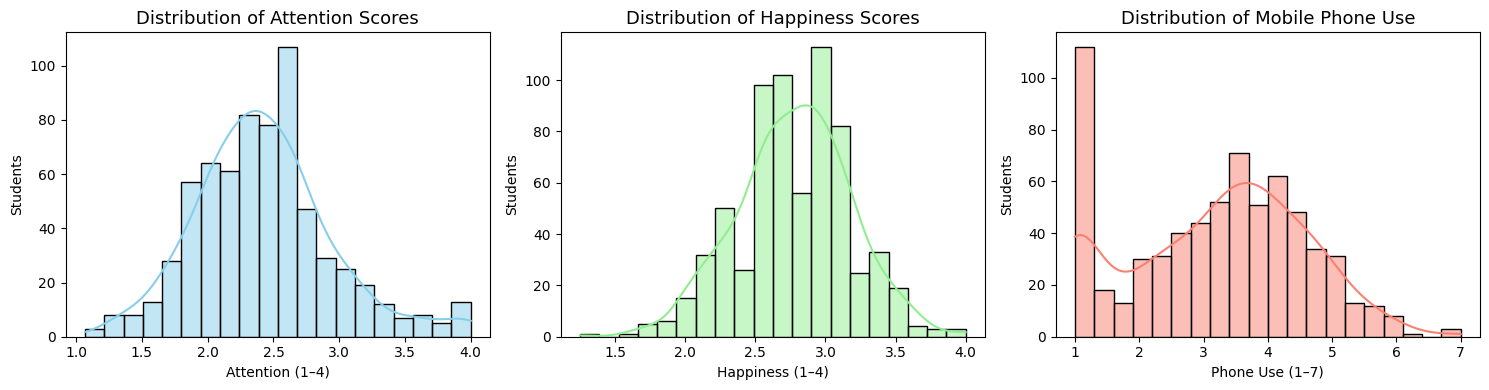

In [22]:

import matplotlib.pyplot as plt
import seaborn as sns
# --- Clean column names just in case ---
df_final.columns = df_final.columns.str.strip().str.lower()

# --- Define key variable names (update if slightly different) ---
attention_col = 'attention_score'
happiness_col = 'happiness_score'
phone_col = 'phoneuse_score'

# --- Set up 3 histograms side-by-side ---
plt.figure(figsize=(15, 4))

# Attention
plt.subplot(1, 3, 1)
sns.histplot(df_final[attention_col], kde=True, bins=20, color='skyblue')
plt.title("Distribution of Attention Scores", fontsize=13)
plt.xlabel("Attention (1–4)")
plt.ylabel("Students")

# Happiness
plt.subplot(1, 3, 2)
sns.histplot(df_final[happiness_col], kde=True, bins=20, color='lightgreen')
plt.title("Distribution of Happiness Scores", fontsize=13)
plt.xlabel("Happiness (1–4)")
plt.ylabel("Students")

# Mobile phone use
plt.subplot(1, 3, 3)
sns.histplot(df_final[phone_col], kde=True, bins=20, color='salmon')
plt.title("Distribution of Mobile Phone Use", fontsize=13)
plt.xlabel("Phone Use (1–7)")
plt.ylabel("Students")

plt.tight_layout()
plt.show()


Using columns: age='age', sex='sex_binary', phone='phoneuse_score'


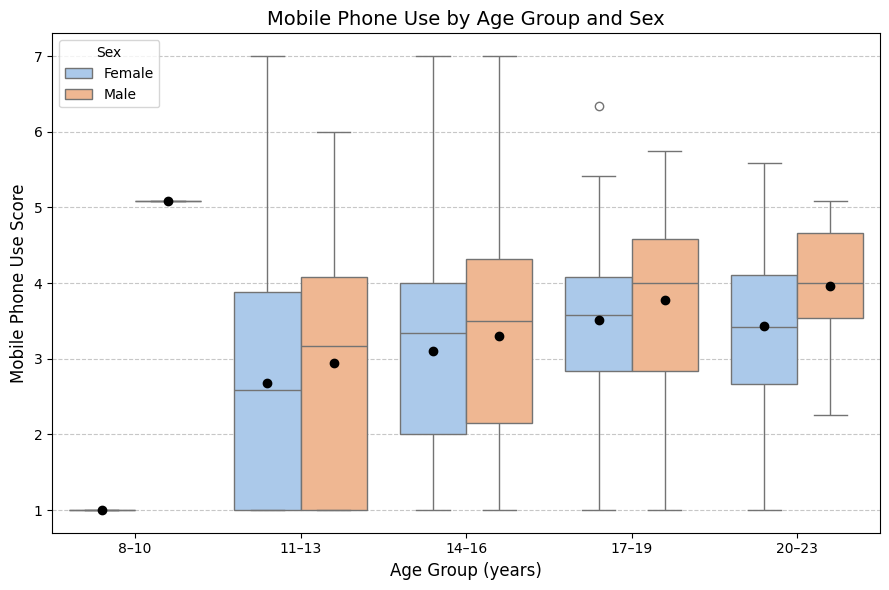

In [23]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype

# --- Load your data (update path as needed) ---
# df_final = pd.read_csv("BF_survey.csv")

# --- 1) Clean column names ---
df_final.columns = df_final.columns.str.strip().str.lower()

# --- 2) Identify relevant columns ---
age_col = 'age'
sex_candidates   = ['sex', 'gender', 'sex_binary']
phone_candidates = ['phoneuse_score', 'mobile_phone_score', 't_score']

sex_col   = next((c for c in sex_candidates if c in df_final.columns), None)
phone_col = next((c for c in phone_candidates if c in df_final.columns), None)

if sex_col is None or phone_col is None or age_col not in df_final.columns:
    raise KeyError(
        f"Required columns not found. "
        f"Have: {df_final.columns.tolist()}\n"
        f"Missing one of: age='{age_col}', sex in {sex_candidates}, phone in {phone_candidates}"
    )

print(f"Using columns: age='{age_col}', sex='{sex_col}', phone='{phone_col}'")

# --- 3) Create readable sex label column (don’t overwrite numeric) ---
def build_sex_label(s):
    if is_numeric_dtype(s):
        vals = set(pd.Series(s).dropna().unique().tolist())
        if vals.issubset({0, 1}):
            mapping = {0: 'Male', 1: 'Female'}
        elif vals.issubset({1, 2}):
            mapping = {1: 'Male', 2: 'Female'}
        else:
            mapping = {v: ('Male' if v <= 1 else 'Female') for v in vals}
        return pd.Series(s).map(mapping)
    else:
        return (
            pd.Series(s)
            .astype('string')
            .str.strip()
            .str.lower()
            .map({'m': 'Male', 'male': 'Male', 'f': 'Female', 'female': 'Female'})
        )

df_final['sex_label'] = build_sex_label(df_final[sex_col]).astype('category')

# --- 4) Convert age and bin it ---
df_final[age_col] = pd.to_numeric(df_final[age_col], errors='coerce')

bins = [7, 10, 13, 16, 19, 23]
labels = ['8–10', '11–13', '14–16', '17–19', '20–23']
df_final['age_group'] = pd.cut(
    df_final[age_col], bins=bins, labels=labels, include_lowest=True, right=True
)

# --- 5) Drop missing values for plotting ---
plot_df = df_final.loc[
    df_final[['age_group', 'sex_label', phone_col]].notna().all(axis=1),
    ['age_group', 'sex_label', phone_col]
].copy()

# --- 6) Plot grouped boxplot ---
plt.figure(figsize=(9, 6))
sns.boxplot(
    data=plot_df,
    x='age_group',
    y=phone_col,
    hue='sex_label',
    palette='pastel',
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"},
)
plt.title("Mobile Phone Use by Age Group and Sex", fontsize=14)
plt.xlabel("Age Group (years)", fontsize=12)
plt.ylabel("Mobile Phone Use Score", fontsize=12)
plt.legend(title="Sex", loc="upper left")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
